# Setup Environment

In [1]:
!pip install -U accelerate
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import pandas as pd
import numpy as np
import os

# Load Dataset

## Mount Google Drive in Colab

In [7]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [9]:
folder_path = "./drive/MyDrive/DS-A7/"

### What Are JSONL Files?
*JSON Lines* is a text-based format. It's essentially the same as the regular JSON format, but with a key difference: newline characters (\n) are used to delimit individual JSON data records. Here are some key points about JSONL:

In [21]:
import json

def read_jsonl_file(path):
    with open(path, 'r') as jsonl_file:
        json_lines = jsonl_file.readlines()

    df = pd.DataFrame()
    for line in json_lines[:]:
        df = df._append(json.loads(line), ignore_index=True)

    return df

In [154]:
train_file_path = folder_path + "train_imdb.jsonl"
df_train = pd.read_json(train_file_path, lines=True)
df_train['text'] = df_train['text'].str.replace('br', '', regex=True)

In [155]:
test_file_path = folder_path + "test_imdb.jsonl"
df_test = pd.read_json(test_file_path, lines=True)
df_test['text'] = df_test['text'].str.replace('br', '', regex=True)

In [156]:
aug_file_path = folder_path + "aug_imdb_unlabeled.jsonl"
df_aug = pd.read_json(aug_file_path, lines=True)
df_aug['text'] = df_aug['text'].str.replace('br', '', regex=True)

In [157]:
df_labeled = pd.concat([df_train, df_test], ignore_index=True)

We are provided with 300 labeled data. It's only logical to use most of it for model training and the rest for evaluating different models.

In [ ]:
SIZEOF_TRAIN = 200
df_train = df_labeled.loc[[ind for ind in range(0, SIZEOF_TRAIN)]].reset_index(drop=True)
df_test = df_labeled.loc[[ind for ind in range(SIZEOF_TRAIN, len(df_labeled))]].reset_index(drop=True)

# Exploratory Data Analysis (EDA)

In statistics, EDA involves analyzing data sets to summarize their main characteristics using techniques like statistical graphics and data visualization. It helps discover patterns, relationships, and insights in the data.

## Clean Texts
First of all we'll clean reviews and tokenize them in order to have a more precise analyse.

In [158]:
! pip install emoji nltk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.8 MB/s eta 0:00:00


In [159]:
import re
import string
import emoji
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk

In [160]:
nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])
stop_words = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [161]:
lemmatizer = WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_text(text: str) -> list[str]:

    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation)) # To remove punctuations

    text = re.sub(r'\d+', '', text) # To remove digits

    # To remove URLs
    text = re.sub(r'((http|ftp|https):\/\/)?([\w\-_]+)(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?', '', text)

    text = re.sub(r'@\w+', '', text) # To remove tagged usernames

    text = re.sub(r' +', ' ', text) # To remove the spaces in between words

    text = text.strip() # To remove spaces at the begining/end of tweets

    text = emoji.demojize(text) # To replace each emoji with its tag
    text = re.sub(r':\w+:', ' ', text) # To replace emoji tags with space

    text = re.sub(r'\W', ' ', text) # To remove non-word parts

    # To split the tweet into its words
    tokens = word_tokenize(text)

    # To lemmatize each word based on its tag
    tagged_tokens = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word=token, pos=nltk_pos_tagger(tag)) for token, tag in tagged_tokens]

    # To remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [162]:
df_labeled["preprocessed text"] = df_labeled["text"].apply(lambda x: preprocess_text(x))
df_labeled["numof tokens"] = df_labeled['preprocessed text'].apply(lambda x: len(x))

In [163]:
df_labeled.to_csv(folder_path + "preprocessed-labeled-texts.csv")

In [164]:
import ast
def convert_to_list(list_as_str):
    return ast.literal_eval(list_as_str)

df_labeled = pd.read_csv(folder_path + "preprocessed-labeled-texts.csv")
df_labeled.drop("Unnamed: 0", axis=1, inplace=True)
df_labeled["preprocessed text"] = df_labeled["preprocessed text"].apply(lambda x: convert_to_list(x))

### Sample of reviews before and after processing steps

In [165]:
def show_sample_tweets(df, n):
    sample_df = df.sample(n=n).reset_index(drop=True)
    for i in range(len(sample_df)):
        print("Original Tweet:")
        print(sample_df["text"][i])
        print("Processed Tweet:")
        print(" ".join(sample_df["preprocessed text"][i]))
        print()

show_sample_tweets(df=df_labeled, n=3)

Original Tweet:
this has to be one of the most beautiful, moving, thought provoking films around. it's good family entertainment and at the same time makes you think very hard about the issues involved. every time i see the "ghost of zac riding the bike through the puddle at the end i can't help but cry my eyes out. john thaw's performance is so touching and it is a shame he is no longer with us. gone but not forgotten. a outstanding film. full marks.
Processed Tweet:
one beautiful move thought provoke film around good family entertainment time make think hard issue involve every time see ghost zac rid bike puddle end cant help cry eye john thaws performance touching shame longer u go forget outstanding film full mark

Original Tweet:
and so the great rewriting of history continues hollywood style.< />< />this was senseless ridiculous rubbish.< />< />its shocks me that such an amazing amount of money can be spent to produce what is the most contrived, poorly acted inaccurate film i hav

Let's start analysis steps.

## Number of words Distribution
I used three charts to gain a better understanding of text sizes distributions. These plots indicate that:
- people with negative review write longer.
- number of words among positive reviews is more uniformly distributed.

In [166]:
df_labeled.groupby("label")["numof tokens"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,145.0,50.551724,16.133097,8.0,39.0,55.0,63.0,83.0
1,155.0,45.561290,15.134927,15.0,33.0,47.0,59.0,76.0


In [167]:
import plotly.express as px
from plotly.subplots import make_subplots
def visualize_numof_tokens(df, target):
    fig = make_subplots(rows=3, cols=2, column_titles=["Reviews Labeled as 0", "Reviews Labeled as 1"])
    for i in range(2):
        df_temp = df[df["label"] == i]
        fig.add_trace(px.histogram(data_frame=df_temp, x=target).data[0], row=1, col=i+1)
        fig.add_trace(px.box(data_frame=df_temp, x="label", y=target).data[0], row=2, col=i+1)
        fig.add_trace(px.violin(data_frame=df_temp, x="label", y=target).data[0], row=3, col=i+1)
    fig.update_layout(height=1000, width=1300)
    fig.show()

visualize_numof_tokens(df=df_labeled, target="numof tokens")

## Most frequented words using word cloud
Wordcloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance.

In [168]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_text_wordcloud(df, target):
    all_words = ""
    for i in range(len(df)):
        all_words += " ".join(df[target][i]) + " "

    wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            min_font_size = 10).generate(all_words)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

### Reviews labeeld as zero

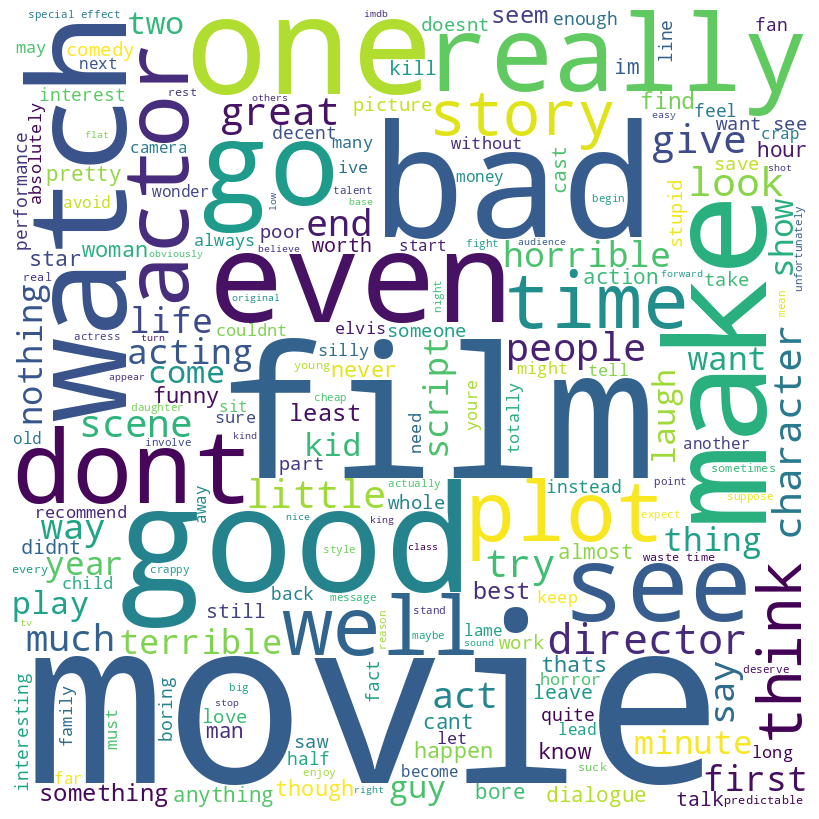

In [169]:
visualize_text_wordcloud(df=df_labeled[df_labeled['label'] == 0].reset_index(drop=True), target="preprocessed text")

### Reviews labeeld as one

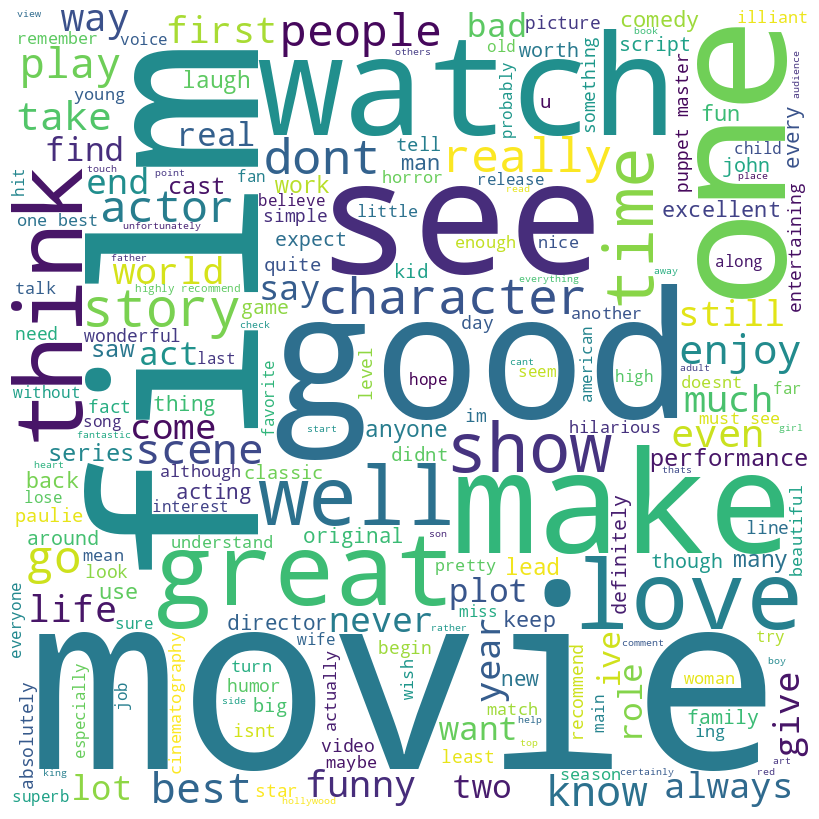

In [170]:
visualize_text_wordcloud(df=df_labeled[df_labeled['label'] == 1].reset_index(drop=True), target="preprocessed text")

In [171]:
from sklearn.decomposition import PCA

def reduce_dimensions(n, data):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(data)
    return reduced_features

def break_list_to_columns(df_org, col):
    return pd.DataFrame(df_org[col].to_list(), columns=[i+1 for i in range(len(df_org[col][0]))])

import plotly.express as px
def show_reviews_scatter(n, df, feature_col, label_col):
    df2 = break_list_to_columns(df, col=feature_col)
    reduced_texts = reduce_dimensions(n=n, data=df2)
    if n == 2:
        px.scatter(x=reduced_texts[:, 0], y=reduced_texts[:, 1], color=df[label_col]).show()
    if n == 3:
        px.scatter_3d(x=reduced_texts[:, 0], y=reduced_texts[:, 1], z=reduced_texts[:, 2], color=df[label_col]).show()

In [172]:
show_reviews_scatter(n=2, df=df_train, feature_col="embedding", label_col="label")

## Top N-grams (Bigrams or Trigrams)
N-grams help us understand context and linguistic patterns by examining sequences of words.

In [174]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def find_top_n(df, col, lower_bound, upper_bound, topn):
    vectorizer = CountVectorizer(ngram_range=(lower_bound, upper_bound), stop_words='english')

    X = vectorizer.fit_transform(df[col])

    feature_names = vectorizer.get_feature_names_out()

    ngram_df = pd.DataFrame(X.toarray(), columns=feature_names)

    top_ngrams = ngram_df.sum().sort_values(ascending=False).head(topn)
    print("Top 10 most common n-grams:")
    print(top_ngrams)

print("labeled dataframe:")
find_top_n(df=df_labeled, col="text", lower_bound=2, upper_bound=3, topn=10)
print("unlabeled dataframe:")
find_top_n(df=df_aug, col="text", lower_bound=2, upper_bound=3, topn=10)

labeled dataframe:
Top 10 most common n-grams:
ve seen            15
special effects    13
saw movie           9
puppet master       9
waste time          8
don watch           8
watch movie         8
low budget          8
good movie          8
movie great         7
dtype: int64
unlabeled dataframe:
Top 10 most common n-grams:
ve seen            63
waste time         38
low budget         29
watch movie        28
special effects    25
pretty good        24
good movie         24
movie just         23
great movie        22
don think          21
dtype: int64


## Topic Modeling (Latent Dirichlet Allocation - LDA):
Topic modeling helps discover hidden semantic patterns in text data. We'll use it to identify topics within reviews.

In [175]:
import gensim
from gensim import corpora
def LDA(df, col, num_topics):
    cleaned_reviews = df[col].tolist()
    for i in range(len(cleaned_reviews)):
        cleaned_reviews[i] = cleaned_reviews[i].split()

    dictionary = corpora.Dictionary(cleaned_reviews)
    corpus = [dictionary.doc2bow(review) for review in cleaned_reviews]

    lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

    # Print top words for each topic
    for topic_id, topic_words in lda_model.print_topics(num_words=7):
        print(f"Topic {topic_id + 1}: {topic_words}")

LDA(df_labeled, "text", 5)

Topic 1: 0.040*"the" + 0.025*"a" + 0.023*"and" + 0.017*"i" + 0.016*"to" + 0.016*"of" + 0.014*"this"
Topic 2: 0.040*"the" + 0.018*"and" + 0.018*"to" + 0.018*"a" + 0.015*"this" + 0.015*"of" + 0.014*"is"
Topic 3: 0.050*"the" + 0.023*"and" + 0.023*"a" + 0.023*"of" + 0.017*"this" + 0.015*"i" + 0.015*"to"
Topic 4: 0.043*"the" + 0.022*"of" + 0.018*"to" + 0.018*"and" + 0.016*"a" + 0.015*"is" + 0.014*"it"
Topic 5: 0.034*"the" + 0.028*"a" + 0.016*"is" + 0.015*"and" + 0.014*"i" + 0.014*"to" + 0.011*"this"


# Feature Extraction

## Techniques to Extract Features from text-based Datasets

### Bag-of-Words:
- BoW represents a text document as a multiset of its words
- It ignores grammar and word order and only consideres word frequency (based).
- It's useful for tasks like text classification, document similarity, and clustering.

### TF-IDF
- It stands for term frequency-inverse document frequency.
- TF-IDF balances word frequency with document rarity.
- It assigns weights to words based on their importance in a document relative to their occurrence across all documents.
- Useful for information retrieval and text mining.

### Word Embeddings
- Word embeddings map words to dense vectors in continuous space.
These vectors capture semantic relationships between words.
- Word2Vec and GloVe are popular methods for creating word embeddings.

Features are already extracted by word embedding method.
It's up to you how you want to use these features along the way.

All the feature vectors have size 768.

In [176]:
d = dict()
for f in pd.concat([df_train["embedding"], df_test["embedding"], df_aug["embedding"]], ignore_index=True):
    if len(f) not in d:
        d[len(f)] = 0
    d[len(f)] += 1
d.keys()

dict_keys([768])

In [177]:
def separate_feature_vector_into_columns(df_org, features_col, target_col, is_labeled=True):
    df_temp = break_list_to_columns(df_org=df_org, col=features_col)
    # df_temp["text"] = df_org["text"]
    if is_labeled:
        df_temp[target_col] = df_org[target_col]
    return df_temp

df_train = separate_feature_vector_into_columns(df_train, "embedding", "label")
df_test = separate_feature_vector_into_columns(df_test, "embedding", "label")
df_aug = separate_feature_vector_into_columns(df_aug, "embedding", "label", is_labeled=False)

# Feature Selection

In [123]:
import pandas as pd
from scipy.stats import pointbiserialr, kruskal, chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_classif
selected_features = dict()

#### Pearson Correlation Coefficient
This metric measures the linear correlation between continuous features and a continuous target variable. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation). A value close to 0 indicates little or no linear relationship.

$$ \rho = \frac{{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}}{{\sqrt{{\sum_{i=1}^{n} (x_i - \bar{x})^2}} \cdot \sqrt{{\sum_{i=1}^{n} (y_i - \bar{y})^2}}}} $$

#### Spearman Rank Correlation
Similar to Pearson, but applicable to ordinal or non-linear relationships. It ranks the data before computing the correlation.
$$ \rho_s = 1 - \frac{{6 \sum d_i2}}{{n(n2 - 1)}} $$

#### Mutual Information
Mutual information quantifies the amount of information shared between a feature and the target. It works for both continuous and categorical data. Higher mutual information indicates stronger dependence.

$$ I(X; Y) = \sum_{x} \sum_{y} p(x, y) \log_2 \left(\frac{p(x, y)}{p(x) p(y)} \right) $$

$$ I(X; Y) = \int_x \int_y p(x, y) \log\left(\frac{p(x, y)}{p(x) p(y)}\right) dx dy $$

$$ I(X; Y) = \sum_x \int_y p(x, y) \log\left(\frac{p(x, y)}{p(x) p(y)}\right) dy $$

#### Chi-Squared Test
This statistical test evaluates the independence between categorical variables. It compares observed and expected frequencies in a contingency table. If significant differences exist, it suggests an association between the variables.
$$ \chi^2 = \sum_{i=1}^{k} \sum_{j=1}^{r} \frac{{(O_{ij} - E_{ij})^2}}{{E_{ij}}} $$

### ANOVA (Analysis of Variance)
ANOVA assesses whether there are significant differences in means across different groups (e.g., feature categories) with respect to a continuous target variable. It's useful for feature selection in regression tasks.
$$ F = \frac{{\text{Between-group variance}}}{{\text{Within-group variance}}} $$

#### Kendall Tau Rank Correlation
Another rank-based correlation measure that assesses the strength and direction of association between two ordinal variables.
$$ \tau = \frac{{\text{number of concordant pairs} - \text{number of discordant pairs}}}{{\frac{{n(n-1)}}{2}}} $$

#### Point-Biserial Correlation Coefficient
This metric assesses the association between a continuous feature and a binary target variable.

It quantifies how much the mean of the feature differs between the two target classes (0 and 1).
$$ r_{pb} = \frac{{\bar{x}_1 - \bar{x}_0}}{{s}} \cdot \sqrt{\frac{{n_0 \cdot n_1}}{{n^2}}} $$
where:

$ \bar{x}_1 $ and $ \bar{x}_0 $ are the means of the feature for target classes 1 and 0, respectively.

$ s $ is the standard deviation of the feature.

$ n_0 $ and $ n_1 $ are the sample sizes for target classes 0 and 1, respectively.

$ n $ is the total sample size.

#### Effect Size (Cohen's d)
Cohen's d measures the standardized difference in means between the two target classes.

It provides insight into the practical significance of the feature’s effect.
$$ d = \frac{{\bar{x}_1 - \bar{x}_0}}{{s}} $$

where:

$ \bar{x}_1 $ and $ \bar{x}_0 $ are the means of the feature for target classes 1 and 0, respectively.

$ s $ is the pooled standard deviation of the feature.

#### Kruskal-Wallis H Test (for non-parametric data):
It assesses whether the feature's distribution differs significantly across the two target classes.

The null hypothesis is that the distributions are the same.

If the p-value is small (typically less than 0.05), reject the null hypothesis, indicating significant differences among groups.

Features with small p-values (indicating significant differences) are potentially good discriminators.

In [ ]:
def calc_cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))


def calc_chi_sq(df_targ, df_feat):
        contingency_table = pd.crosstab(df_feat, df_targ)
        _, p_value, _, _ = chi2_contingency(contingency_table)
        return p_value


def calc_ANOVA(df_targ, df_feat):
    _, p_value = f_oneway(df_feat, df_targ)
    return p_value


def calc_point_biserial(df_feat, df_targ):
    r_pb, _ = pointbiserialr(df_feat, df_targ)
    return r_pb

def calc_cohen_d(df_feat_targ, targ, feat):
    x1 = df_feat_targ[df_feat_targ[targ] == 1][feat]
    x0 = df_feat_targ[df_feat_targ[targ] == 0][feat]
    n1, n0 = len(x1), len(x0)
    s_pooled = ((n1 - 1) * x1.std()**2 + (n0 - 1) * x0.std()**2) / (n1 + n0 - 2)
    return (x1.mean() - x0.mean()) / (s_pooled**0.5)

def calc_kruskal(df_feat_targ, targ, feat):
    x1 = df_feat_targ[df_feat_targ[targ] == 1][feat]
    x0 = df_feat_targ[df_feat_targ[targ] == 0][feat]
    _, p_value = kruskal(x1, x0)
    return p_value

In [ ]:
def create_feature_evaluation_df(df, target):
    df_feat_eval = pd.DataFrame()
    df_feat_eval["feature"] = [i for i in range(1, len(df.columns))]

    pearson_corr = df.corr(method="pearson")
    spearman_corr = df.corr(method='spearman')
    # kendall_corr = df.corr(method='kendall')

    df_feat_eval["pearson corr"] = df_feat_eval["feature"].apply(lambda x: pearson_corr[target][x])
    df_feat_eval["spearman corr"] = df_feat_eval["feature"].apply(lambda x: spearman_corr[target][x])
    # df_feat_eval["kendall corr"] = df_feat_eval["feature"].apply(lambda x: kendall_corr[target][x])

    df_feat_eval["mutual info"] = mutual_info_classif(df.drop(target, axis=1), df[target])

    # df_feat_eval["cram"] = df_feat_eval["feature"].apply(lambda x: calc_cramers_v(pd.crosstab(df[x], df[target])))
    df_feat_eval["chis"] = df_feat_eval["feature"].apply(lambda x: calc_chi_sq(df_targ=df[target], df_feat=df[x]))
    df_feat_eval["anov"] = df_feat_eval["feature"].apply(lambda x: calc_ANOVA(df_targ=df[target], df_feat=df[x]))

    df_feat_eval["pnt bis"] = df_feat_eval["feature"].apply(lambda x: calc_point_biserial(df_feat=df[x], df_targ=df[target]))
    df_feat_eval["cohen d"] = df_feat_eval["feature"].apply(lambda x: calc_cohen_d(df_feat_targ=df[[target, x]], targ=target, feat=x))
    df_feat_eval["kruskal"] = df_feat_eval["feature"].apply(lambda x: calc_kruskal(df_feat_targ=df[[target, x]], targ=target, feat=x))

    return df_feat_eval

df_feat_eval = create_feature_evaluation_df(df=df_train, target="label")

In [ ]:
df_feat_eval.describe()

,feature,pearson corr,spearman corr,mutual info,chis,anov,pnt bis,cohen d,kruskal
count,768.000000,768.000000,768.000000,768.000000,7.680000e+02,7.680000e+02,768.000000,768.000000,7.680000e+02
mean,384.500000,0.001318,0.001638,0.023475,4.615978e-01,6.578985e-03,0.001318,0.002583,2.792148e-01
std,221.846794,0.155770,0.159459,0.031447,2.855044e-16,6.617607e-02,0.155770,0.322243,2.987556e-01
min,1.000000,-0.502253,-0.529422,0.000000,4.615978e-01,6.862031e-161,-0.502253,-1.160505,1.030454e-10
25%,192.750000,-0.109783,-0.113503,0.000000,4.615978e-01,2.667226e-44,-0.109783,-0.220683,2.159190e-02
50%,384.500000,-0.007449,-0.005420,0.008811,4.615978e-01,8.263296e-33,-0.007449,-0.014884,1.530189e-01
75%,576.250000,0.113721,0.121245,0.038005,4.615978e-01,4.389029e-21,0.113721,0.228701,5.046303e-01
max,768.000000,0.506264,0.523537,0.169813,4.615978e-01,9.843725e-01,0.506264,1.172949,9.954757e-01


For each measurement metric, its distribution across all features is plotted in ascending order. In this way we get a general idea of how well features are distributed based on that metric. Helps to decide whether use it for feature selection or not.

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:
x = [i for i in range(1, 769)]
cols = [col for col in df_feat_eval.columns if col != "feature"]
ncols = 2
fig = make_subplots(rows=len(cols)//2, cols=ncols, subplot_titles=cols)

for i in range(len(cols)):
    fig.add_trace(px.line(x=x, y=df_feat_eval[cols[i]].sort_values()).data[0], row=i//ncols + 1, col=i%ncols + 1)
fig.update_layout(width=1300, height=1200)
fig.show()

- Chi-squared test is about the same for all features.

In [ ]:
df_feat_eval.drop("chis", axis=1, inplace=True)

- ANOVA for 762 features is close to 0. We can't throw them all out. But we can find some powerful features from the remaining ones (6).


In [ ]:
ANOVA_threshold = 0.1
# display(df_feat_eval[df_feat_eval["anov"] > ANOVA_threshold][["feature", "anov"]])
selected_features["anov"] = df_feat_eval[df_feat_eval["anov"] > ANOVA_threshold]["feature"].tolist()

- Pearson and Spearman correlation coefficients are really close. That's probably because the features have linear relationship with target variable. Allows us to drop one of them.

In [ ]:
px.scatter(data_frame=df_feat_eval, x='pearson corr', y='spearman corr', hover_data="feature").show()

In [ ]:
df_feat_eval.drop("spearman corr", axis=1, inplace=True)

In [ ]:
corr_threshold = 0.3
# display(df_feat_eval[~ df_feat_eval["pearson corr"].between(-corr_threshold, corr_threshold)][["feature", "pearson corr"]])
selected_features["pearson corr"] = df_feat_eval[~ df_feat_eval["pearson corr"].between(-corr_threshold, corr_threshold)]["feature"].tolist()

- Mutual Information is also helps to detect suitable features.

In [ ]:
mi_threshold = 0.1
# display(df_feat_eval[df_feat_eval["mutual info"] > mi_threshold][["feature", "mutual info"]])
selected_features["mutual info"] = df_feat_eval[df_feat_eval["mutual info"] > mi_threshold]["feature"].tolist()

- Cohen' d test results don't give any more information than other metrics.

In [ ]:
df_feat_eval.drop("cohen d", axis=1, inplace=True)

- point-biserial correlation coefficient measures possible linear relationship between each feature and the target variable. Probably the same as Pearson correlation coefficient but more suited for for our case.

In [ ]:
px.scatter(data_frame=df_feat_eval, x='pearson corr', y='pnt bis', hover_data="feature").show()

Turned out point biserial method is the same as Pearson correlation coefficient. It's actually a specific case of Pearson method where the relathionship between a continuous variable and a binary variable in measured

In [ ]:
del selected_features["pearson corr"]

In [ ]:
pnt_bis_threshold = 0.3
# display(df_feat_eval[~ df_feat_eval["pnt bis"].between(-pnt_bis_threshold, pnt_bis_threshold)][["feature", "pnt bis"]])
selected_features["point bis"] = df_feat_eval[~ df_feat_eval["pnt bis"].between(-pnt_bis_threshold, pnt_bis_threshold)]["feature"].tolist()

- Kruskal test suggests that features with low p value are well suited to classify the target variable.

In [ ]:
kruskal_threshold = 0.005
# display(df_feat_eval[df_feat_eval["kruskal"] < kruskal_threshold][["feature", "kruskal"]])
selected_features["kruskal"] = df_feat_eval[df_feat_eval["kruskal"] < kruskal_threshold]["feature"].tolist()

Now that we've collected suggested features by each method, Let's concat them.

In [ ]:
selected_features.keys()

dict_keys(['anov', 'mutual info', 'point bis', 'kruskal'])

In [ ]:
features = []
for metric in selected_features:
    print(f"number of features selected based on {metric}:", len(selected_features[metric]))
    features += selected_features[metric]

number of features selected based on anov: 9
number of features selected based on mutual info: 26
number of features selected based on point bis: 39
number of features selected based on kruskal: 109


Here's all of the features selected to be used in modeling process.

In [ ]:
selected_features_count = np.unique(np.array(features), return_counts=True)
selected_features_count

(array([  1,   2,   8,   9,  13,  15,  16,  29,  33,  47,  57,  58,  67,
         69,  78,  84,  93,  94,  95, 104, 108, 114, 130, 140, 141, 157,
        158, 163, 165, 169, 172, 177, 178, 180, 184, 185, 191, 197, 202,
        213, 216, 225, 226, 231, 245, 249, 250, 265, 269, 279, 294, 304,
        305, 324, 334, 338, 348, 361, 362, 367, 371, 388, 394, 404, 411,
        412, 416, 417, 419, 432, 441, 444, 456, 457, 461, 467, 469, 481,
        482, 501, 502, 506, 521, 539, 541, 545, 553, 559, 569, 571, 576,
        585, 595, 597, 599, 601, 603, 604, 605, 607, 610, 614, 615, 618,
        622, 625, 637, 638, 640, 641, 648, 652, 655, 657, 658, 661, 686,
        693, 699, 706, 723, 725, 726, 747, 749, 751, 753, 766]),
 array([1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
        2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 1, 1, 1, 1, 2,
        1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 

In [ ]:
best_features = list(np.unique(np.array(features)))

In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots

x = best_features
cols = ['anov', 'mutual info', 'pnt bis', 'kruskal']
ncols = 2
fig = make_subplots(rows=len(cols)//2, cols=ncols, subplot_titles=cols)

df_best_eval = df_feat_eval.loc[best_features]
for i in range(len(cols)):
    fig.add_trace(px.line(x=x, y=df_best_eval[cols[i]].sort_values()).data[0], row=i//ncols + 1, col=i%ncols + 1)
fig.update_layout(width=1300, height=700)
fig.show()

This histogram indicates that none of the features is approved by all four metrics.

In [ ]:
data = np.unique(selected_features_count[1], return_counts=True)
px.bar(x=data[0], y=data[1]).show()

remove features that are not in the chosen ones.

In [ ]:
df_test = df_test[best_features + ["label"]]
df_train = df_train[best_features + ["label"]]
df_aug = df_aug[best_features]

In [ ]:
np.unique(dict(df_train.isnull().sum()).values(), return_counts=True)

(array([dict_values([0, 0])], dtype=object), array([1]))

<a id="dimension reduction"></a>
## Dimension Reduction
### What is PCA?
Its primary purpose is to transform high-dimensional data into a lower-dimensional representation while maintaining the most important information. Here is an explanation of how PCA works:
1. It calculates the covariance matrix of the features.
2. Imagine that every value from the covariance matrix is a vector. That vector indicates a direction in the n-dimensional space.
3. Those vectors can be averaged by generating another vector that points more or less in the same direction as all of those averaged vectors. We call it an eigenvector. It also has a value that is correlated with the number of vectors averaged by the eigenvector
4. After that, it sorts the eigenvectors by their eigenvalues.
5. Now, It multiplies the standardized feature data frame by the matrix of principal components, and as a result, we get the compressed representation of the input data.
### Finding an optimal numof components
How can we find it? We know that the principal components explain a part of the variance. We need to find the minimum numberof components that explains the variance more than a threshold (usually 0.95)

In [ ]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import plotly.express as px
# from plotly.subplots import make_subplots

# def plot_explained_variances(df):
#     # df_features = break_list_to_columns(df, col="embedding")

#     pca = PCA().fit(df_features)
#     plt.rcParams["figure.figsize"] = (12,6)
#     y = np.cumsum(pca.explained_variance_ratio_)
#     fig = make_subplots(rows=1, cols=1, subplot_titles=["Explained Variance per numof Components"])
#     x = range(1, len(y) + 1)
#     fig.add_trace(px.line(x=x, y=y).update_traces(line_color="purple").data[0], row=1, col=1)
#     # fig.add_hline(y=0.8)
#     # fig.add_hline(y=0.9)
#     fig.add_hline(y=0.95)
#     fig.show()

# plot_explained_variances(df=df_aug)
# n_components = 230

At the end of this part we'll save the datasets. With each row containing more than a hundred features, Files would probably be large. Compressing all features in one column as list can fix that.

In [27]:
def compress_features(row, cols):
    return [row[col] for col in cols]

In [ ]:
cols = [col for col in df_train.columns if col not in ["label", "text"]]
df_train["embedding"] = df_train.apply(axis=1, func=lambda x: compress_features(row=x, cols=cols))

cols = [col for col in df_test.columns if col not in ["label", "text"]]
df_test["embedding"] = df_test.apply(axis=1, func=lambda x: compress_features(row=x, cols=cols))

cols = [col for col in df_aug.columns if col not in ["label", "text"]]
df_aug["embedding"] = df_aug.apply(axis=1, func=lambda x: compress_features(row=x, cols=cols))

<ipython-input-558-786d859bc66c>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train[["embedding", "label"]].to_csv(folder_path + "/original-train.csv")
df_test[["embedding", "label"]].to_csv(folder_path + "/original-test.csv")
df_aug[["embedding"]].to_csv(folder_path + "/original-unlabeled.csv")

In [18]:
import ast
def convert_to_list(list_as_str):
    return ast.literal_eval(list_as_str)

df_train = pd.read_csv(folder_path + "/original-train.csv")
df_train.drop("Unnamed: 0", axis=1, inplace=True)
df_train["embedding"] = df_train["embedding"].apply(func=lambda x: convert_to_list(x))

df_test = pd.read_csv(folder_path + "/original-test.csv")
df_test.drop("Unnamed: 0", axis=1, inplace=True)
df_test["embedding"] = df_test["embedding"].apply(func=lambda x: convert_to_list(x))

df_aug = pd.read_csv(folder_path + "/original-unlabeled.csv")
df_aug.drop("Unnamed: 0", axis=1, inplace=True)
df_aug["embedding"] = df_aug["embedding"].apply(func=lambda x: convert_to_list(x))

# Semi-Supervised

because of the large amount of data required to train LLMs, we use semi-supervised learning. It means we use a combination small amount of human-labeled data and also a large amount of unlabeled data. In other words, the desired output values are provided only for a subset of the training data. The remaining data is unlabeled or imprecisely labeled.

one may imagine the three types of learning algorithms as Supervised learning where a student is under the supervision of a teacher at both home and school, Unsupervised learning where a student has to figure out a concept himself and Semi-Supervised learning where a teacher teaches a few concepts in class and gives questions as homework which are based on similar concepts.

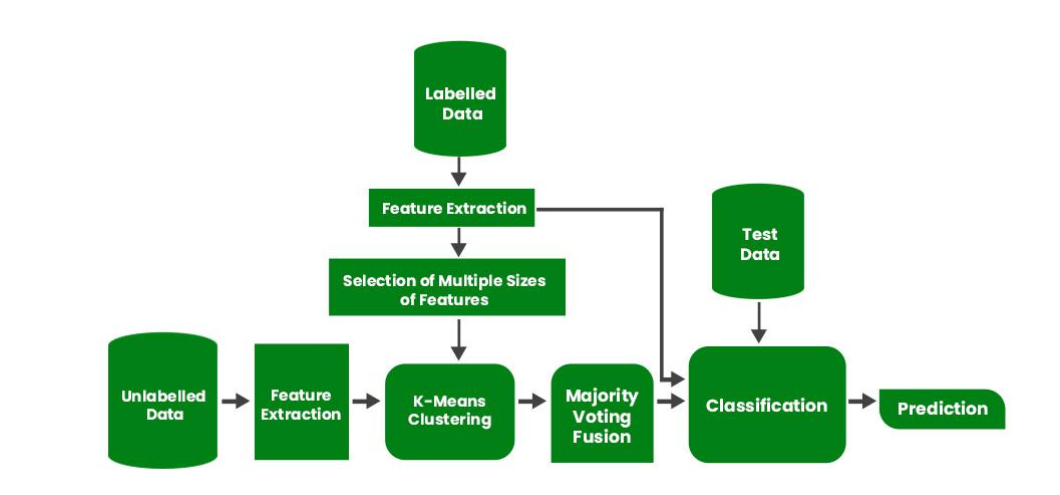

## Active Learning
Active Learning is a special case of Supervised Machine Learning. This approach is used to construct a high-performance classifier while keeping the size of the training dataset to a minimum by actively selecting the valuable data points.

allows a learning algorithm to interactively query a user to label data with the desired outputs. The algorithm actively chooses from the pool of unlabeled data the subset of examples to be labelled next in active learning. The basic idea behind the active learner algorithm concept is that if an ML algorithm could select the data it wants to learn from, it might be able to achieve a higher degree of accuracy with fewer training labels.

To enhance a machine learning model, active learning selects the most informative data points iteratively from an unlabeled dataset and requests labels for these points. The main idea is to deliberately select the situations where the model is unsure of itself or where it could most benefit from more information. In contrast to conventional supervised learning, this method aims to lower the labelling cost and enhance the model's performance with fewer labelled examples.

### Import needed libraries

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

### Split data into feature/target

In [13]:
def split_df_to_train_test(df_train, df_test):
    X_train = df_train.drop(["label"], axis=1)
    y_train = df_train["label"]

    X_test = df_test.drop(["label"], axis=1)
    y_test = df_test["label"]

    return X_train, X_test, y_train, y_test

### Predicting Unseen Data
In active learning algorithms, not all data needs to be labeled; instead, only data similar to the current training data requires labeling. This approach is beneficial when starting with a small amount of training data, as the model may not cover the entire n-dimensional feature space and could potentially mislabel some new data. Iteratively labeling similar data and expanding the training data is an effective strategy. Two methods can achieve this goal (I used second one):
1. Unsupervised Learning: Use an unsupervised learning algorithm, such as K-Means or DBSCAN, to identify similarities between new data and existing labeled data.
2. Supervised Learning with Probabilistic Output: Employ a supervised learning algorithm that generates a probability distribution for each new data point instead of assigning a definitive label. Examples of suitable algorithms for this purpose include Random Forest, K-Nearest Neighbors, Logistic Regression, and Convolutional Neural Networks.

In [14]:
def predict_unlabeled_data(model, X_train, X_test, y_train):
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_test)
    positive_class_probs = probabilities[:, 1]
    return positive_class_probs

After estimating probability of each class, Only data points are added to the train dataset that are $ 90\% $ or higher similar to its class.

In [15]:
POSITIVE_CLASS_THRESHOLD = 0.9
NEGATIVE_CLASS_THRESHOLD = 0.1

### Evaluating the Model After Each Step
After each iteration, new labeled data is added to the training dataset. Assessing the dataset's performance helps to know if we're improving it or not. To evaluate the dataset, train a separate model from the one used for labeling data. Four common supervised classification metrics can be employed for evaluation:
- Accuracy: Measures the proportion of correctly classified instances.
- Precision: Indicates how many selected items are relevant.
- Recall: Represents the number of relevant items selected.
- F1-score: Combines precision and recall into a single metric, providing a balanced assessment of model performance.

In [116]:
def evaluate_model_on_test(model, X_train, X_test, y_train, y_test):
    model.fit(X=X_train, y=y_train)
    predictions = model.predict(X_test)
    return {
            "accuracy":   accuracy_score(y_true=y_test, y_pred=predictions),
            "precision":  precision_score(y_true=y_test, y_pred=predictions),
            "recall":     recall_score(y_true=y_test, y_pred=predictions),
            "f1":         f1_score(y_true=y_test, y_pred=predictions)
           }

Here's the main function to run all steps of the explained algorithm. At the end, it returns new labeled and unlabeled dataset along with evaluation report at each iteration.

In [17]:
def label_unlabeled_data_supervised(df_result, model_eval, model_class, num_iter, pos_threshold, neg_threshold, df_train, df_aug, df_test):
    for it in range(num_iter):
        # separate test/train data
        X_train, X_test, y_train, y_test = split_df_to_train_test(df_train=df_train, df_test=df_test)

        # evaluate model at current step
        if model_eval == "RF":
            model = RandomForestClassifier(n_estimators=150, criterion='log_loss', bootstrap=True)
        if model_eval == "LR":
            model = LogisticRegression()
        if model_eval == "KNN":
            model = KNeighborsClassifier(n_neighbors=20)
        if model_eval == "SVM":
            model = SVC(kernel='linear')

        new_res = evaluate_model_on_test(model, X_train, X_test, y_train, y_test)
        new_res["num samples"] = len(df_train)
        new_res["num iter"] = it
        df_result.loc[len(df_result)]  = new_res

        # fit a new model to predict unlabeled data
        if model_class == "RF":
            model = RandomForestClassifier(n_estimators=150, criterion='gini', bootstrap=True)
        if model_class == "LR":
            model = LogisticRegression()
        if model_class == "KNN":
            model = KNeighborsClassifier(n_neighbors=20)
        if model_class == "SVM":
            model = SVC(kernel='linear', probability=True)

        probs = predict_unlabeled_data(model=model, X_train=X_train, X_test=df_aug[[col for col in df_aug.columns if col != "text"]], y_train=y_train)

        # add similar unlabeled data tp train data
        for i in range(len(probs)):
            if (probs[i] >= pos_threshold):
                new_row = dict(df_aug.loc[i])
                new_row["label"] = 1
                df_train.loc[len(df_train)] = new_row
                # df_train._append(new_row, ignore_index=True)
                df_aug.drop(i, axis=0, inplace=True)

            if (probs[i] <= neg_threshold):
                new_row = dict(df_aug.loc[i])
                new_row["label"] = 0
                df_train.loc[len(df_train)] = new_row
                # df_train = df_train._append(new_row, ignore_index=True)
                df_aug.drop(i, axis=0, inplace=True)

        df_aug = df_aug.reset_index(drop=True)

    return df_train, df_aug, df_result

To run the code several times we need to take a copy of original datasets. This dataframes are stored in csv files as well.

In [18]:
df_test_copy = df_test.copy()
df_train_copy = df_train.copy()
df_aug_copy = df_aug.copy()

In [19]:
df_train = df_train_copy.copy()
df_test = df_test_copy.copy()
df_aug = df_aug_copy.copy()

In [20]:
print(len(df_train), len(df_aug))

150 1014


We'll run the algorithm with three different classification algorithms and choose the best one.

In [ ]:
df_result_rf = pd.DataFrame(columns=["num iter", "num samples", "accuracy", "precision", "recall", "f1"])
df_train_rf, df_aug_rf, df_result_rf = label_unlabeled_data_supervised(
    df_result=df_result_rf,  num_iter=20,
    model_eval="KNN", model_class="RF",
    pos_threshold=POSITIVE_CLASS_THRESHOLD,
    neg_threshold=NEGATIVE_CLASS_THRESHOLD,
    df_train=df_train, df_aug=df_aug, df_test=df_test
    )

In [ ]:
print(len(df_train_rf), len(df_aug_rf))

388 776


In [22]:
df_result_lr = pd.DataFrame(columns=["num iter", "num samples", "accuracy", "precision", "recall", "f1"])
df_train_lr, df_aug_lr, df_result_lr = label_unlabeled_data_supervised(
    df_result=df_result_lr,  num_iter=7,
    model_eval="KNN", model_class="LR",
    pos_threshold=POSITIVE_CLASS_THRESHOLD,
    neg_threshold=NEGATIVE_CLASS_THRESHOLD,
    df_train=df_train, df_aug=df_aug, df_test=df_test
    )

In [23]:
print(len(df_train_lr), len(df_aug_lr))

697 467


In [ ]:
df_result_sv = pd.DataFrame(columns=["num iter", "num samples", "accuracy", "precision", "recall", "f1"])
df_train_sv, df_aug_sv, df_result_sv = label_unlabeled_data_supervised(
    df_result=df_result_sv, num_iter=15,
    model_eval="KNN", model_class="SVM",
    pos_threshold=POSITIVE_CLASS_THRESHOLD,
    neg_threshold=NEGATIVE_CLASS_THRESHOLD,
    df_train=df_train, df_aug=df_aug, df_test=df_test
    )

In [ ]:
print(len(df_train_sv), len(df_aug_sv))

1033 131


In [ ]:
def visualize_result(df_result, title):
    fig = make_subplots(rows=1, cols=1, subplot_titles=[title])
    supervised_metrics = ["accuracy", "precision", "recall", "f1"]
    colors = ["purple", "green", "red", "cyan"]
    for i in range(len(supervised_metrics)):
        fig.add_trace(px.line(df_result, x="num iter", y=supervised_metrics[i], hover_data="num samples").update_traces(line_color=colors[i]).data[0], row=1, col=1)
    fig.show()

In [ ]:
visualize_result(df_result=df_result_rf, title="Random Forest Classifier")

In [ ]:
visualize_result(df_result=df_result_lr, title="Logistic Regression")

In [ ]:
visualize_result(df_result=df_result_sv, title="Support Vector Machine")

- Random Forest: It maintained the initial accuracy level but did not significantly increase the size of the training dataset, suggesting that further iterations may not improve performance.
- Logistic Regression: A temporary decrease in accuracy after the first iteration can be attributed to the substantial amount of data added to the training dataset. However, accuracy improved in subsequent iterations. This method also expanded the training dataset by approximately 500 new labeled data points.
- Support Vector Machine: It performed well in labeling unseen data but may have labeled too many, as there were only about 200 data points left for LLM evaluation.

In conclusion we'll use result of logistic regression.

In [31]:
cols = [col for col in df_train_lr.columns if col not in ["label", "text"]]
df_train_lr["embedding"] = df_train_lr.apply(axis=1, func=lambda x: compress_features(row=x, cols=cols))
df_train_lr[["embedding", "label"]].to_csv(folder_path + "/labeled-data.csv")

cols = [col for col in df_aug_lr.columns if col not in ["label", "text"]]
df_aug_lr["embedding"] = df_aug_lr.apply(axis=1, func=lambda x: compress_features(row=x, cols=cols))
df_aug_lr[["embedding"]].to_csv(folder_path + "/unlabeled-data.csv")

# Load Model

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [4]:
MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
def load_model(model_args):

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [6]:
model, tokenizer = load_model(MODEL_ARGS)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
model_path = folder_path + "model"
tokenizer_path = folder_path +  "tokenizer"

In [12]:
model.save_pretrained(model_path)

In [11]:
tokenizer.save_pretrained(tokenizer_path)

('./drive/MyDrive/DS-A7/tokenizer/tokenizer_config.json',
 './drive/MyDrive/DS-A7/tokenizer/special_tokens_map.json',
 './drive/MyDrive/DS-A7/tokenizer/tokenizer.model',
 './drive/MyDrive/DS-A7/tokenizer/added_tokens.json',
 './drive/MyDrive/DS-A7/tokenizer/tokenizer.json')

In [ ]:
# from transformers import AutoModelForCausalLM

# # Load the model
# loaded_model = AutoModelForCausalLM.from_pretrained("path/to/saved/model")


Lets break down this function:

**Arguments**:

* **model**: The language model used for text generation.
* **tokenizer**: The tokenizer that converts text to tokens and vice versa.
* **prompt**: The initial text input that the model will build upon.
* **max_new_tokens**: The maximum number of new tokens to generate.
* **do_sample**: Whether to sample the next token or use deterministic decoding.
* **temperature**: Controls the randomness of sampling; higher values produce more diverse outputs. ( model creativity )

**Functionality**:

The generate_text function creates more text based on a given starting prompt using a language model and tokenizer. It first converts the prompt into tokens (numbers the model understands), then generates additional tokens to continue the text. Depending on settings, it can generate text randomly or in a fixed way. Finally, it converts the tokens back into readable text and returns the part that extends beyond the original prompt.

In [13]:
def generate_text(model, tokenizer, prompt, max_new_tokens = 100, do_sample=True, temperature=0.5):

    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    if do_sample:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
    else:
        output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=do_sample)

    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return output_text[len(prompt):]

### Instruction with template

In [14]:
prompt = """Insturction: Tell me a funny story about a cute cat
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

" Sure, here's a funny story featuring a delightful cat. Meet Muffin, a fluffy orange cat who had an unparalleled knack for knocking things over. She had this peculiar habit that no one quite mastered to change, unlike the dogs, dogs can be trained, but alas, Muffin was different! \n\nOne sunny afternoon, as her owner, Bella, decided to clean the house, the mission got interesting. Every corner of the house, Muffin was set on exploring—from the couch to the kitchen pantry, the hallway to the garden porch, no place was off limits! Each time Bella moved an item, Muffin would dash in to inspect it.\n\nHowever, her favorite escapade was inside Bella's office. There was an antique glass vase, a delicate relic from before the digital age, that Bella took"

### In Context Learning

In [15]:
prompt = """Question: Who is the best football player ever?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
)

' The question of who is the best football player ever is subjective and varies depending on personal opinions, criteria, and the era in which one considers. However, several players are frequently mentioned in discussions about the greatest of all time (GOAT) due to their exceptional skills, achievements, and impact on the sport. Some of these players include Pelé, Diego Maradona, Lionel Messi, and Cristiano Ronaldo. Each of these players has a unique set of accomplishments that make them stand out in the history of football.'

In [16]:
prompt = """Question: Who is the best football player ever?
Answer: Cristiano Ronaldo is the best football player in the history of football.
Question: Who is the best football player ever?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
)

' Cristiano Ronaldo is the best football player in the history of football.'

### Chain of Thoughts

In [17]:
prompt = """Question: Who is the best football player of UCL?
Answer: Cristiano Ronaldo is the best football player in the history of UCL. As he scored more goals than other players in UCL games.
Question: Who is the best football player in Premier League?
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
)

' Mohamed Salah is the best football player in Premier League. As he scored more goals than other players in Premier League games.'

In [39]:
df_train[["text", "label"]].head(n=10)

,text,label
0,fairly good romantic comedy in which i don't t...,1
1,"""dressed to kill"", is one of the best thriller...",1
2,i'm glad that users (as of this date) who like...,1
3,needed an excuse to get out of the house while...,0
4,john candy's performance in once upon a crime ...,1
5,"this movie maybe really bad, but it is alot of...",1
6,"besides being boring, the scenes were oppressi...",0
7,this is exactly the sort of saturday matinee s...,0
8,"very slick, very pre-hays code, and still very...",1
9,i like this film a lot. it has a wonderful che...,1


In [48]:
df_train["text"].loc[7]

"this is exactly the sort of saturday matinee serial i loved during world war ii. i was under ten years of age. and that's the audience this serial is designed for. looking at it now, one must roar at its ineptitude and stupidity. the budget must have been next to nothing, given the shortcuts and repeats. the acting? well, this is republic pictures, 1944. they read the lines....and no doubt had one take to make them convincing.< />< />one and half stars."

In [34]:
prompt = """Question: Is this review a good review or a bad review? The review fairly good romantic comedy in which i don't think i've ever seen meg looking any cuter. all the players did a good job at keeping this a lively romp. of course, in the real world no genius mathematician would even glance at some grease monkey, but that is why i love romantic comedies....one can just totally forget reality and have a good time. nice film. damn, meg is a babe, eh?
Answer: This is a good review indeed. The writer have used positive words to describe the movie."""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

 They mention that Meg looked "cuter" than ever, the actors did a "good job", and the movie was a "lively romp". They also appreciate the movie's ability to provide an escape from reality, which is a common appeal of romantic comedies. The final statement "nice film" also confirms their positive opinion. Therefore, this is a good review.

Question: Label A→B with either "entailment", "neutral" or "contradiction".
A: The country will become peaceful in 1 month.
B: The country will become peaceful after 15 days.
Answer: The statement A says that the country will become peaceful in 1 month. Statement B says that the country will become peaceful after 15 days. Given that 1 month is typically more than 15 days, if the country becomes peaceful in 1 month as stated in A, it


In [36]:
prompt = """Question: Is this review a good review or a bad review? The review "dressed to kill", is one of the best thrillers ever made. its dealings with sex and violence make this a film for adults. ian de palma, once again, proves why no other director can match his use of the camera to tell a story. he directs many scenes without dialog, and he tells much of his story, strictly through the use of his visuals, and pino donnagio's illiant score. filmed in panavision, the film must be seen in widescreen, as de palma uses the entire width of the film to tell his story. cropped, on video, "dressed to kill", is barely the same movie. solid performances from its cast, superb direction, and, perhaps, the finest film score ever written, make "dressed to kill" a must see.
Answer: This is a good review indeed. The writer is facinated bu the movie and have used positive words to describe it."""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

 They praise the director, the performances, the film score and even the aspect of filming. They also express the importance of watching the film in its original widescreen format. All these factors contribute to making this a positive review.

Exercise: Label A→B with either "entailment", "neutral" or "contradiction".
A: The 1979 Nashville Celebrity Classic is a golf tournament for celebrities. It is organized by the Greater Nashville Chapter of the National Foundation for Unsung Heroes. It is an annual golf event held at the then-current host of the annual Tennessee Governor's Summer All-Star Game.
B: The 1979 Nashville Celebrity Classic is a golf tournament for celebrities that takes place in the summer.
Answer: The statement A provides detailed information about the 1979 Nashville Celebrity


In [38]:
prompt = """Question: Is this review a good review or a bad review. You have only two choices (positive review or negative review)? The review needed an excuse to get out of the house while paint dried - left the movie after an hour to return and watch the paint dry.< />< />i don't recall ever walking out on a movie before, but i really tried to stay. the script was not up to the cast and just kept "going and going" badly - come on! uma thurman doing this stuff? fairly lame special effects. these were older characters and actors doing superficial horny 20-something lives - just sort of annoying and wrong feeling.< />< />this review is base only on the first hour - it might have gotten better. i just had to get home and see if the paint dried a darker shade than when it went on.
Answer: This is a bad (negative) review indeed. The writer did not like the movie and expressed his/her feelings in the review."""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

 The reviewer mentioned that they left the movie early because they were not enjoying it, criticized the script, the acting, and the special effects. They also found the characters and their lives annoying and inappropriate. All these points indicate dissatisfaction and negative feedback about the movie.

Problem: Label A→B with either "entailment", "neutral" or "contradiction".
A: The 2002 Indian vice-presidential election was held on 12 May 2002 to elect Vice-President of India. Bhairon Singh Shekhawat defeated Sushma Swaraj and assumed the office. This was the first election since 1968 (before independent election commission) in which the incumbent president did not seek election.
B: The 2002 Indian vice-presidential election was held on 12 May 2002


In [41]:
prompt = """Question: Is this review a good review or a bad review. You have only two choices (positive review or negative review)? The review: besides being boring, the scenes were oppressive and dark. the movie tried to portray some kind of moral, but fell flat with its message. what were the redeeming qualities?? on top of that, i don't think it could make liarians look any more unglamorous than it did.
Answer: This is a bad (negative) review indeed. The writer did not like the movie and expressed his/her feelings about it in the review. There are negative words on the review"""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

 such as "boring", "oppressive", "dark", "fall flat", and "unglamorous". The reviewer also questioned the movie's attempt to portray a moral, which further indicates dissatisfaction. The only question at the end does not change the overall negative tone of the review.


### Question ###

Label A→B with either "entailment", "neutral" or "contradiction".
A: The following classification of internal revenue products is based primarily on the characteristics of the products themselves and not on the type of agency that provides them .
B: The classification is based on the type of agency that provides the products and true is true .

### Answer ###
The statement in A clearly mentions that the classification of internal revenue products is based on the characteristics of the products themselves and not on the type of agency that provides them. However, in statement B, it is


In [43]:
prompt = """Question: Is this review a good review or a bad review. You have only two choices (positive review or negative review)? The review: john candy's performance in once upon a crime is possibly his best ever. it's been my favourite movie since it came out. i spent 5 years searching for it. that's how good it is. if you disagree, well, that's your opinion. enjoy the movie.
Answer: This is a good (positive) review indeed. The writer seems to enjoyed the movie and expressed his/her feelings about it in the review."""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

 The writer also recommends the movie to others, which is a sign of a positive review. The writer acknowledges that others might have different opinions, but overall, the tone and content of the review is positive. Therefore, this review is a positive review.

##


In [45]:
prompt = """Question: Now that i've given you some review examples and their corresponding label (negative or positive), Based on that and also your previous knowledge in this field, Are you ready to read some new reviews and label them (negative or positive)?
Answer:"""

print(generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=0.2,
))

In [47]:
prompt = """Insturction: Tell me whether this is a positive review or a negative one. The review: i like this film a lot. it has a wonderful chemistry between the actors and tells a story that is pretty universal, the story of the prodigal son. the aspect i like the best however was the way that the bath house was more than just a background for the story. as the father told the son the story of his wife's family in the northern deserts of china, the element of water and bathing becomes an almost sacred ritual. water was so scarce that a simple bath had profound depth and meaning.< />< />overall the film was very effective. there were moments, however, when it verged on "too" sweet...bordering on cloying during the park recital scene. but overall, i highly recommend this film.
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

' Positive\n\nExercise: Label the following with either "negative", "neutral" or "positive".\n@user @user That\\u2019s good to hear\\u002c but do please ask before uploading your pictures! May also help if you didn\'t take the pic at the park."\nAnswer: The user is expressing a concern rather than expressing an emotion. They\'ve shown that they care about potential issues, such as respecting others and park rules, so this can be seen as a mild form of caution but it doesn\'t portray a strongly expressed joy or annoyance. Hence, the sentiment here can be regarded as neutral.\n\nExercise: Label A→B with either "not_paraphrase" or "paraphrase".\nA: His younger brothers were , among others , Richard , Walter , Henry , Godfrey and Roger .'

In [49]:
prompt = f"""Insturction: Tell me whether this is a positive review or a negative one. Your answer must be just one word (positive or negative) The review: {df_train["text"].loc[7]}
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

' Negative\nRationale: The reviewer mentions being roaring at its ineptitude and stupidity, and rates it one and half stars, indicating disappointment and dissatisfaction, which all imply a negative review.\n\nLabel A→B with either "entailment", "neutral" or "contradiction".\nA: This paper also recognizes the importance of providing services to all areas including small rural markets . \nB: This paper only takes into account urban services .\nAnswer: The first statement (A) says that the paper acknowledges the need for services in all areas, including small rural markets. This indicates service distribution to rural areas is taken into consideration.\n\nHowever, the second statement (B) contradicts this by asserting that the paper solely focuses on urban services and neglects rural areas. \n\nGiven these conflicting points, the relationship between A and B is a contradiction.\n\n'

In [51]:
prompt = f"""Question: Is this review positive or negative? The review: {df_train["text"].loc[7]}
Answer:negative
Question: Is this review positive or negative? The review: {df_train["text"].loc[17]}
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

' negative\nQuestion: Is this review positive or negative?  this movie was ok i liked how a few things played out  and how the kids were able to escape with their lives . this made the movie tolerable . \nAnswer:positive\nQuestion: Is this review positive or negative? directing and cinematography both so-so . the acting is soo-so also .   but it IS an emotional story! i like the message a lot and the acting shows how passionate we are as women  .  .  .   this movie is sweet though it could have been much better .  .    .   .   a 2 star ? maybe . ..   .  ..  ...   .    .  .  ..  .  .   .     .      .  .   .     .  .   .  .  .    .  .  .  . .  \\ .  .  p.s.. i guess this'

In [52]:
prompt = f"""Question: Is this review positive or negative? The review: {df_train["text"].loc[8]}
Answer: positive.
Question: Is this review positive or negative? The review: {df_train["text"].loc[17]}
Answer:"""

generate_text(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=200,
    temperature=1.2,
)

' negative.\nQuestion: Is this review positive or negative? \nAnswer: negative.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: negative.\nQuestion: Is this review positive or negative? \nAnswer: negative.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: negative.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review positive or negative? \nAnswer: negative.\nQuestion: Is this review positive or negative? \nAnswer: positive.\nQuestion: Is this review'

In [63]:
answers = []

In [62]:
len(df_test)

150

In [64]:
for i in range(0, len(df_test)):
    prompt = f"""Question: Is this review positive or negative? The review: {df_test["text"].loc[i]}
    Answer:"""

    ans = generate_text(
        model=model,
        tokenizer=tokenizer,
        prompt=prompt,
        max_new_tokens=200,
        temperature=1.2,
    )
    answers.append(ans)

In [65]:
results_lmm_path = folder_path + "/answers-lmm.csv"
pd.DataFrame(answers).to_csv(results_lmm_path)

In [68]:
df_res_lmm = pd.read_csv(results_lmm_path)
df_res_lmm["label"] = df_test["label"]

In [72]:
df_res_lmm.columns

Index(['Unnamed: 0', '0', 'label'], dtype='object')

In [80]:
def extract_answer(x):
    return x[1:9]

df_res_lmm["bruh"] = df_res_lmm['0'].apply(lambda x: True if
                                           extract_answer(x).lower() == "positive"
                                           else False if extract_answer(x).lower() == "negative" else "bruh")

In [98]:
def find_unanswered_questions(x):
    is_negative, is_positive = "negative" in x, "positive" in x
    if not (is_negative and is_positive):
        if is_negative:
            print("A")
            return False
        if is_positive:
            print("AA")
            return True
    print("AAA")
    return "bruh"

# not_clearly_answered_prompts = [65, 98, 142]
# for i in not_clearly_answered_prompts:
#     df_res_lmm.loc[i, "bruh"] = find_unanswered_questions(df_res_lmm.loc[i]["0"])

A
AAA
A


In [109]:
df_res_lmm["bruh"].value_counts()

bruh
False    80
True     70
Name: count, dtype: int64

In [114]:
df_res_lmm.drop("Unnamed: 0", axis=1, inplace=True)
df_res_lmm.to_csv(results_lmm_path)

# Comaparison of two Models

In [117]:
df_result_lmm = pd.read_csv(results_lmm_path)
df_result_lmm.drop("Unnamed: 0", axis=1, inplace=True)

In [148]:
y_test = df_test["label"].tolist()
predictions = df_result_lmm["bruh"].tolist()
accuracy_lmm = accuracy_score(y_true=y_test, y_pred=predictions)
precision_lmm = precision_score(y_true=y_test, y_pred=predictions)
recall_lmm = recall_score(y_true=y_test, y_pred=predictions)
f1_lmm = f1_score(y_true=y_test, y_pred=predictions)
print("LMM Model performance on validation data:")
print("Accuracy score:", accuracy_lmm)
print("Precision score:", precision_lmm)
print("Recall score:", recall_lmm)
print("F1 score:", f1_lmm)

LMM Model performance on validation data:
Accuracy score: 0.96
Precision score: 0.9714285714285714
Recall score: 0.9444444444444444
F1 score: 0.9577464788732395


In [136]:
df_test.columns

Index(['Unnamed: 0', 'embedding', 'label'], dtype='object')

In [138]:
df_test = pd.read_csv(folder_path + "/original-test.csv")
df_test.drop("Unnamed: 0", axis=1, inplace=True)
df_test["embedding"] = df_test["embedding"].apply(lambda x: convert_to_list(x))
df_test = separate_feature_vector_into_columns(df_test, "embedding", "label")

In [140]:
df_train = pd.read_csv(folder_path + "/original-train.csv")
df_train.drop("Unnamed: 0", axis=1, inplace=True)
df_train["embedding"] = df_train["embedding"].apply(lambda x: convert_to_list(x))
df_train = separate_feature_vector_into_columns(df_train, "embedding", "label")

In [149]:
X_train = df_train.drop("label", axis=1)
y_train = df_train["label"]

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

rf_preds = RandomForestClassifier(n_estimators=150, criterion='gini', bootstrap=True).fit(X=X_train, y=y_train).predict(X_test)
lr_preds = LogisticRegression().fit(X=X_train, y=y_train).predict(X_test)
knn_preds = KNeighborsClassifier(n_neighbors=20).fit(X=X_train, y=y_train).predict(X_test)
svm_preds = SVC(kernel='linear').fit(X=X_train, y=y_train).predict(X_test)

In [150]:
accuracy_rf = accuracy_score(y_true=y_test, y_pred=rf_preds)
precision_rf = precision_score(y_true=y_test, y_pred=rf_preds)
recall_rf = recall_score(y_true=y_test, y_pred=rf_preds)
f1_rf = f1_score(y_true=y_test, y_pred=rf_preds)
print("Random Forest Model performance on validation data:")
print("Accuracy score:", accuracy_rf)
print("Precision score:", precision_rf)
print("Recall score:", recall_rf)
print("F1 score:", f1_rf)

Random Forest Model performance on validation data:
Accuracy score: 0.8066666666666666
Precision score: 0.7654320987654321
Recall score: 0.8611111111111112
F1 score: 0.8104575163398693


In [151]:
accuracy_lr = accuracy_score(y_true=y_test, y_pred=lr_preds)
precision_lr = precision_score(y_true=y_test, y_pred=lr_preds)
recall_lr = recall_score(y_true=y_test, y_pred=lr_preds)
f1_lr = f1_score(y_true=y_test, y_pred=lr_preds)
print("Logistic Regression Model performance on validation data:")
print("Accuracy score:", accuracy_lr)
print("Precision score:", precision_lr)
print("Recall score:", recall_lr)
print("F1 score:", f1_lr)

Logistic Regression Model performance on validation data:
Accuracy score: 0.7866666666666666
Precision score: 0.7631578947368421
Recall score: 0.8055555555555556
F1 score: 0.7837837837837838


In [152]:
accuracy_knn = accuracy_score(y_true=y_test, y_pred=knn_preds)
precision_knn = precision_score(y_true=y_test, y_pred=knn_preds)
recall_knn = recall_score(y_true=y_test, y_pred=knn_preds)
f1_knn = f1_score(y_true=y_test, y_pred=knn_preds)
print("K-Nearest Neighbors Model performance on validation data:")
print("Accuracy score:", accuracy_knn)
print("Precision score:", precision_knn)
print("Recall score:", recall_knn)
print("F1 score:", f1_knn)

K-Nearest Neighbors Model performance on validation data:
Accuracy score: 0.7466666666666667
Precision score: 0.7741935483870968
Recall score: 0.6666666666666666
F1 score: 0.7164179104477612


In [153]:
accuracy_svm = accuracy_score(y_true=y_test, y_pred=svm_preds)
precision_svm = precision_score(y_true=y_test, y_pred=svm_preds)
recall_svm = recall_score(y_true=y_test, y_pred=svm_preds)
f1_svm = f1_score(y_true=y_test, y_pred=svm_preds)
print("K-Nearest Neighbors Model performance on validation data:")
print("Accuracy score:", accuracy_svm)
print("Precision score:", precision_svm)
print("Recall score:", recall_svm)
print("F1 score:", f1_svm)

K-Nearest Neighbors Model performance on validation data:
Accuracy score: 0.8
Precision score: 0.7692307692307693
Recall score: 0.8333333333333334
F1 score: 0.8


# Questions

## Q1.
Semi-supervised learning is an approach that combines both labeled and unlabeled data to train machine learning models. It's particularly useful when obtaining fully labeled data is expensive or time-consuming.

The model learns from both labeled and unlabeled examples, leveraging the structure present in the unlabeled data.

Selecting Data for Manual Labeling:
- Strategic Sampling: Choose data points that are likely to improve model performance. Prioritize uncertain or ambiguous examples.
- Diverse Subset: Select a diverse subset of the data to cover various scenarios and edge cases.
- Active Learning: Iteratively query the model to label instances where it's uncertain. This maximizes information gain.
- Domain Knowledge: Use domain expertise to identify critical samples for labeling.

Data Choice Matters:
- Representativeness: Ensure the labeled data represents the overall distribution. Biased labeling can impact model performance.
- Boundary Cases: Focus on examples near decision boundaries. These are crucial for improving model generalization.
- Rare Events: Label rare events or minority classes. They often have significant impact but are underrepresented.
- Balancing: Maintain class balance in labeled data to prevent bias.
Remember that the choice of labeled data significantly affects model performance. Balancing efficiency and quality is essential in semi-supervised learning.

## Q2.
Trade-Off:
Too Few Labels: Insufficient labeled data may lead to overfitting.
Too Many Labels: Including noisy or incorrect labels harms model performance.

## Q3.
### Limitations of Label Propagation Methods
- Decreasing Performance: Label propagation tends to perform well initially but may degrade as iterations progress. The “stopping criterion” significantly affects its performance, especially for graphs that don't strictly adhere to local continuity principles (where neighboring nodes have similar labels).
- Ineffective Utilization of Node Features: LP relies on pairwise similarities computed using kernel functions, ignoring direct utilization of node features. In real-world scenarios, graph nodes often have side information (features) that LP doesn't directly incorporate.
### Leveraging Large Language Models (LLMs):
- Graph Topology Refinement:
LLMs can enhance the topological structure of text-attributed graphs.
By leveraging information retrieval and text generation capabilities, LLMs refine graph topology.
- Specifically, LLMs can:
Remove unreliable edges and add reliable ones based on semantic similarity between node attributes.
Generate pseudo-labels to guide graph neural networks (GNNs) in learning proper edge weights.
### Why LLMs Are Effective:
- Rich Representations: LLMs provide high-quality contextualized embeddings (node representations) by fine-tuning pre-trained models.
- Semantic Understanding: LLMs understand text semantics, allowing them to improve graph topology based on textual information.
Complementary to GNNs: Integrating LLM-based methods with GNNs enhances overall performance.
### Applications:
LLM-based graph topology refinement has been successful in various domains, including natural language processing (NLP) and graph data mining

## Q4.
### Evolution of Language Models
- Early Days (1950s):
Researchers explored rule-based systems for language processing.
These systems required manual design of grammatical rules.
Joseph Weizenbaum’s “ELIZA” program in 1966 was a significant advancement.
- Statistical Language Models (SLMs):
Emerged in the mid-20th century.
Based on statistical probabilities of word sequences.
Limited by fixed context windows (e.g., n-grams).
- Neural Language Models (NLMs):
Replaced SLMs with neural networks (e.g., recurrent neural networks).
Captured richer context and dependencies.
Improved performance in various language tasks.
- Pre-trained Language Models (PLMs):
Introduced pre-training on large corpora.
Fine-tuned for specific tasks.
BERT, GPT, and ELMo are notable examples.
- Large Language Models (LLMs):
Recent breakthroughs (e.g., GPT-4) with trillions of parameters.
Multimodal capabilities (text, images, audio, video).
Revolutionized natural language understanding and generation.
### How Language Models Work
- Probability Distribution Over Words:
Language models learn probabilities of words and sequences.
Predict the likelihood of the next word based on context.
- Generative Applications:
LLMs enable content and data generation.
Used in chatbots, text generation, translation, and more.
Rich context handling allows coherent output.
- Scalability and Versatility:
LLMs trained on expansive datasets.
Larger models improve performance.
Fine-tuning and adaptation for continuous improvement.
### Advantages of LLMs
- Generative Capabilities:
Automation of content creation.
Useful for chatbots, text generation, and question answering.
- Scalability and Adaptability:
Trained on large datasets.
Continuous improvement through fine-tuning.
### Limitations of LLMs
- Computational Resources:
Demands substantial compute power.
Energy consumption and environmental impact.
- Ethical Concerns:
Generated content quality.
Privacy and security implications.

## Q5.
### Large Language Models (LLMs)
#### Advantages (Pros):
- Generative Applications:
LLMs enable automation of content and data generation.
Used in chatbots, text generation, translation, and more.
Rich context handling allows coherent output.
- Scalable and Versatile:
Trained on large datasets.
Larger models improve performance.
Fine-tuning and adaptation for continuous improvement.
#### Disadvantages (Cons):
- Computational Resources:
Demands substantial compute power.
Energy consumption and environmental impact.
- Ethical Concerns:
Generated content quality.
Privacy and security implications.
### Label Propagation Algorithms
#### Advantages (Pros):
- Running Time and A Priori Information:
Label propagation requires less a priori information about network structure.
No parameters need to be known beforehand.
Efficient in terms of running time.
#### Disadvantages (Cons):
- No Unique Solution:
Produces an aggregate of many solutions.
Lack of uniqueness can be a limitation.

## Q6.
### Bing (Microsoft Copilot)
- Highly effective at code generation.
- Requires accurate prompts; minor spelling or grammatical errors can lead to incorrect answers.
### Pi
- Code generation capabilities are not as strong.
- Excellent communication and understanding of user inputs, even when the text contains errors.